## 1. Importing dependencies and Data

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Importing the data recorded from the pressure ports

In [212]:
pressures = pd.read_csv('raw_testG41.csv')
pressures.columns
pressures.dtypes

  Run_nr    object
    Time    object
   Alpha    object
Delta_Pb    object
   P_bar    object
             ...  
    P109    object
    P110    object
    P111    object
    P112    object
    P113    object
Length: 121, dtype: object

Importing the coordinates of each static port on the airfoil

In [213]:
airfoil_ports = pd.read_csv('airfoil_coordinates.csv')
airfoil_ports.columns

Index(['Port Name', 'x', 'y'], dtype='object')

## 2. Processing to floats

In [214]:
pressures = pressures.drop(labels=0)

In [215]:
pressures.columns = pressures.columns.str.strip(' ')
pressures.columns

Index(['Run_nr', 'Time', 'Alpha', 'Delta_Pb', 'P_bar', 'T', 'rpm', 'rho',
       'P001', 'P002',
       ...
       'P104', 'P105', 'P106', 'P107', 'P108', 'P109', 'P110', 'P111', 'P112',
       'P113'],
      dtype='object', length=121)

In [216]:
pressures = pressures.drop(labels= ['Time', 'Run_nr'], axis=1)

In [217]:
pressures = pressures.astype(float)

## 3. Transform from pressure distribution to dimensionless coefficient $C_p \: [-]$

In [218]:
pressures['q_inf'] = 0.211804 + 1.928442*pressures['Delta_Pb'] + 1.879374 *10**(-4) * (pressures['Delta_Pb'])**2 # in pascal

In [219]:
pressures.loc[:, 'P001':'P113'] = (pressures.loc[:, 'P001':'P113']).add(pressures.loc[:, 'P_bar'] * 1e2, axis=0)

In [220]:
pressures['p_s'] = pressures['P097'] - pressures['q_inf']

In [221]:
cp_distributions = pressures.copy()

cp_distributions.loc[:, 'P001':'P049'] = ((pressures.loc[:, 'P001':'P049']).subtract(pressures.loc[:, 'p_s'], axis=0)).div(pressures.loc[:, 'q_inf'], axis = 0)

In [222]:
cp_distributions.head()

cp_distributions.to_csv('processed_cp.csv')

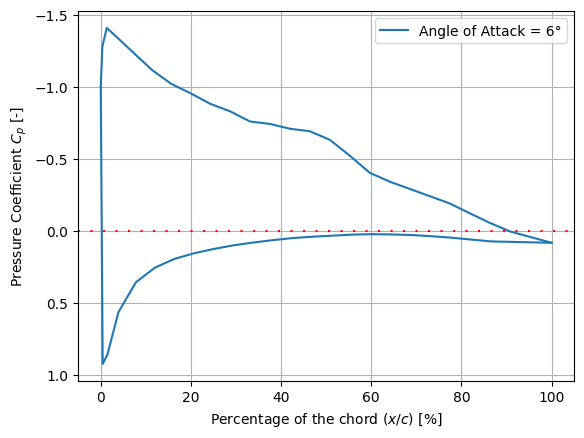

In [223]:
# select your angle of attack!

aoa = 6 

if aoa in pressures['Alpha'].values:
    temp = cp_distributions[cp_distributions['Alpha'] == aoa].copy(deep=True).reset_index()
else: 
    raise Exception('This angle of attack was not measured during the test or the number is inserted incorrectly')

colors = ['tab:blue', 'tab:orange']

for i in range(len(temp)):
    upper = temp.loc[i, 'P001':'P025'].to_numpy().flatten()
    lower = temp.loc[i, 'P026':'P049'].to_numpy().flatten()

    plt.plot(airfoil_ports['x'][0:25], upper, color= colors[i], label=f'Angle of Attack = {aoa}°')
    plt.plot(airfoil_ports['x'][25:49], lower, color= colors[i])
    
plt.axhline(0.0, linestyle=(0, (1, 5)), color='red')
plt.grid()
plt.xlabel('Percentage of the chord $(x/c)$ [%]')
plt.ylabel(r'Pressure Coefficient $C_p$ [-]')
plt.gca().invert_yaxis()

plt.legend()
plt.show()

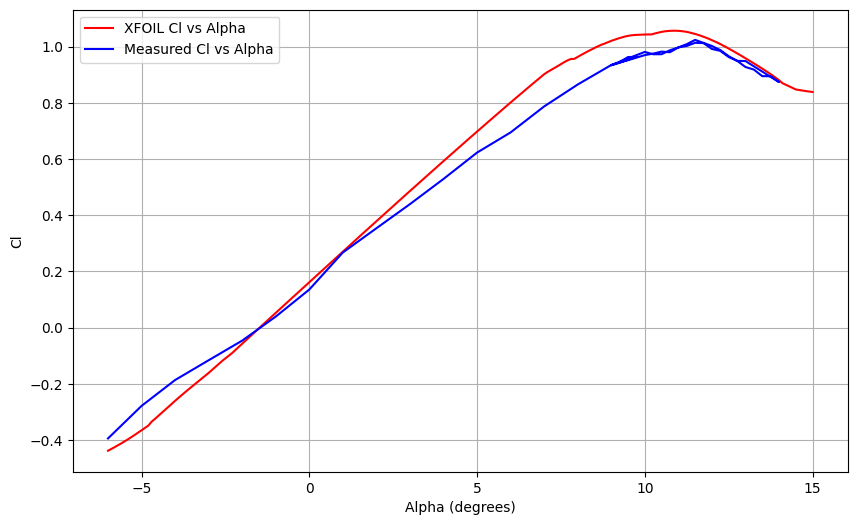

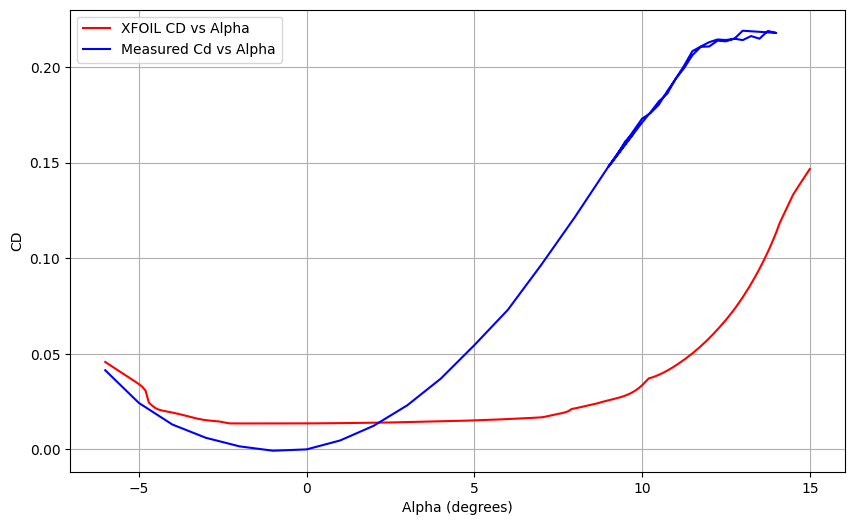

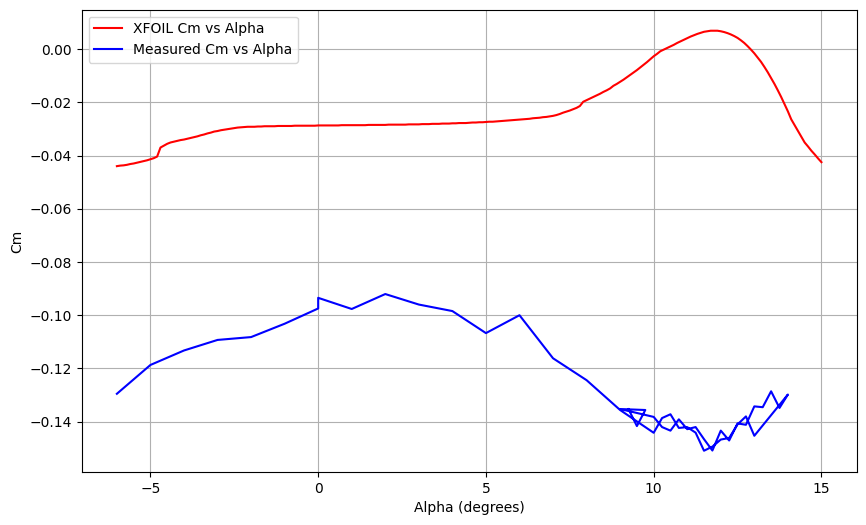

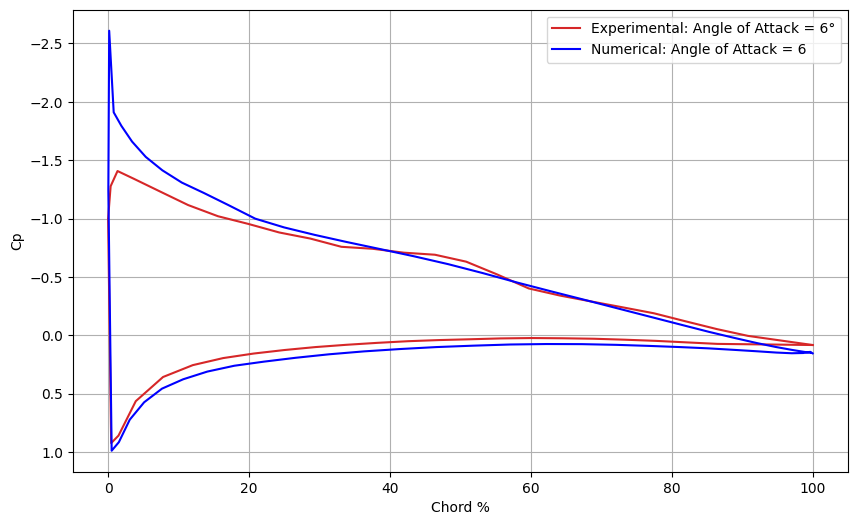

The maximum CL is 1.06 at alpha = 10.90 degrees.


In [224]:
# select your angle of attack!
aoa = 6


# Load the data from the file, skipping the header lines
data = np.genfromtxt('SD6060-104-88_T1_Re0.225_M0.06_N9.0_XtrTop15%_XtrBot15%.txt', skip_header=12)
Cp_data = np.genfromtxt(f'2D_XFLR_Cp_{aoa}deg.txt', skip_header=7)

# Extracting the columns for CL, CD, and Cm (columns 2, 3, and 5)
alpha = data[:, 0]  # Alpha (angle of attack) is the first column
CL = data[:, 1]     # CL is the second column
CD = data[:, 2]     # CD is the third column 
Cm = data[:, 4]     # Cm is the fifth column 

#% chord length
chord_fraction = Cp_data[:, 0] * 100  # Alpha (angle of attack) is the first column
cp = Cp_data[:, 2]  # Alpha (angle of attack) is the first column

# Filter the data for -6° <= alpha <= 15°
filtered_indices = (alpha >= -6) & (alpha <= 15)
alpha_filtered = alpha[filtered_indices]
CL_filtered = CL[filtered_indices]
CD_filtered = CD[filtered_indices]
Cm_filtered = Cm[filtered_indices]

# Find the maximum of the lift curve (CL)
max_CL_index = np.argmax(CL_filtered)
max_CL = CL_filtered[max_CL_index]
max_alpha = alpha_filtered[max_CL_index]


# Wind Tunnel data
aoa_tunnel = [-6, -5, -4, -3, -2, -1, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10.25, 10.5, 10.75, 11, 11.25, 11.5, 11.75, 12, 12.25, 12.5, 12.75, 13, 14, 13.75, 13.5, 13.25, 13, 12.75, 12.5, 12.25, 12, 11.75, 11.5, 11.25, 11, 10.75, 10.5, 10.25, 10, 9, 9.75, 9.5, 9.25]
Cl_tunnel = [-0.393910346, -0.278156012, -0.186107295, -0.115729483, -0.045840272, 0.039584538, 0.135775102, 0.135811407, 0.267583277, 0.353789704, 0.439685792, 0.529191376, 0.622973864, 0.694710091, 0.787163562, 0.865147331, 0.934563178, 0.981139634, 0.972765184, 0.972955583, 0.987033268, 0.997072492, 1.008699816, 1.023880674, 1.01326347, 1.002174385, 0.987596782, 0.966019644, 0.94923684, 0.948678069, 0.873788675, 0.894480651, 0.894948509, 0.918314031, 0.927425683, 0.949636875, 0.962961712, 0.984763809, 0.991645612, 1.012409974, 1.013583759, 1.002309236, 0.997150678, 0.980045729, 0.982184619, 0.975065996, 0.969756541, 0.933716154, 0.963252569, 0.962881674, 0.945157627]
Cd_tunnel = [0.041401646, 0.024335498, 0.01301389, 0.006065125, 0.001600778, -0.000690951, 0, 0, 0.004670683, 0.012354609, 0.023042956, 0.037004666, 0.054503151, 0.073016973, 0.096651532, 0.121588528, 0.148020266, 0.173001389, 0.1759046, 0.180326659, 0.187394121, 0.193811259, 0.200642868, 0.208310877, 0.210759105, 0.213018741, 0.214428281, 0.214161399, 0.214790368, 0.21901959, 0.217859985, 0.218878023, 0.214858128, 0.216234251, 0.21411309, 0.214880887, 0.213483472, 0.213813182, 0.210780782, 0.210581577, 0.206215946, 0.199371703, 0.193826457, 0.186067495, 0.182037159, 0.176320655, 0.170994243, 0.14788611, 0.165517063, 0.161131132, 0.153928694]
Cm_tunnel = [-0.1295528, -0.118723629, -0.11328203, -0.109317356, -0.10824409, -0.103225844, -0.097493466, -0.093493034, -0.097684795, -0.092068382, -0.096017938, -0.098466648, -0.106748939, -0.100028773, -0.116210632, -0.124439225, -0.135659411, -0.144211733, -0.138679523, -0.137253205, -0.142388664, -0.14209267, -0.144166309, -0.150956447, -0.14941918, -0.146758566, -0.146164202, -0.141067724, -0.138064526, -0.145337553, -0.12983706, -0.134880853, -0.128620381, -0.134595977, -0.134291879, -0.14120612, -0.140687848, -0.14710211, -0.143402204, -0.150882599, -0.14660939, -0.14206259, -0.142855442, -0.139157666, -0.143411084, -0.142063775, -0.138246839, -0.135288344, -0.135653598, -0.141691773, -0.135342149]

#Cl
plt.figure(figsize=(10, 6))
plt.plot(alpha_filtered, CL_filtered, label='XFOIL Cl vs Alpha', color="r")
plt.plot(aoa_tunnel, Cl_tunnel, label='Measured Cl vs Alpha', color="b")
#plt.axvline(x=max_alpha, linestyle='--', color='red', label=f'Max CL at ({max_alpha:.2f}, {max_CL:.2f})')
#plt.axhline(y=max_CL, linestyle='--', color='red')
plt.xlabel('Alpha (degrees)')
plt.ylabel('Cl')
plt.grid(True)
plt.legend()
#plt.savefig("Lift.svg", format="svg")
plt.show()

#Cd
plt.figure(figsize=(10, 6))
plt.plot(alpha_filtered, CD_filtered, label='XFOIL CD vs Alpha', color='r')
plt.plot(aoa_tunnel, Cd_tunnel, label='Measured Cd vs Alpha', color="b")
plt.xlabel('Alpha (degrees)')
plt.ylabel('CD')
plt.grid(True)
plt.legend()
#plt.savefig("Drag.svg", format="svg")
plt.show()

#Cm
plt.figure(figsize=(10, 6))
plt.plot(alpha_filtered, Cm_filtered, label='XFOIL Cm vs Alpha', color='r')
plt.plot(aoa_tunnel, Cm_tunnel, label='Measured Cm vs Alpha', color="b")
plt.xlabel('Alpha (degrees)')
plt.ylabel('Cm')
plt.grid(True)
plt.legend()
#plt.savefig("Moment.svg", format="svg")
plt.show()


if aoa in pressures['Alpha'].values:
    temp = cp_distributions[cp_distributions['Alpha'] == aoa].copy(deep=True).reset_index()
else: 
    raise Exception('This angle of attack was not measured during the test or the number is inserted incorrectly')

colors = ['tab:red', 'tab:orange']

#Cp
plt.figure(figsize=(10, 6))
for i in range(len(temp)):
    upper = temp.loc[i, 'P001':'P025'].to_numpy().flatten()
    lower = temp.loc[i, 'P026':'P049'].to_numpy().flatten()
    
    plt.plot(airfoil_ports['x'][0:25], upper, color= colors[i], label=f'Experimental: Angle of Attack = {aoa}°')
    plt.plot(airfoil_ports['x'][25:49], lower, color= colors[i])

plt.plot(chord_fraction, cp, label=f'Numerical: Angle of Attack = {aoa}', color='b')
plt.xlabel('Chord %')
plt.ylabel('Cp')
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis()
#plt.savefig("Cp.svg", format="svg")
plt.show()


print(f"The maximum CL is {max_CL:.2f} at alpha = {max_alpha:.2f} degrees.")
